In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.visualization.spectrogram import draw_spec_set
from avgn.utils.buckeye_utils import VOWEL_CONSONANT
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms


### load data

In [5]:
DATASET_ID = 'buckeye'

In [6]:
df_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'phones_uniform_32.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/buckeye/phones_uniform_32.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,24.457298,24.722471,ah,uh,0,0,0,0,s25,0,o,f,s2501b,16000,"[[0, 0, 0, 0, 0, 1, 0, 19, 97, 138, 152, 160, ..."
1,24.722471,24.792000,ih,it's,1,1,0,1,s25,0,o,f,s2501b,16000,"[[195, 168, 157, 159, 157, 156, 159, 157, 155,..."
2,24.792000,24.847660,t,it's,2,1,1,1,s25,0,o,f,s2501b,16000,"[[235, 216, 198, 187, 172, 158, 146, 128, 105,..."


In [9]:
# individuals
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s25,s08,s24,s40,s15,s17,s13,s16,s26,s35,...,s32,s01,s14,s28,s29,s31,s39,s04,s33,s21
0,25202,22740,20594,20875,24782,15757,27232,34809,13275,26874,...,17189,14526,26115,20719,23643,15280,20782,19112,17679,13974


In [10]:
# most frequent_phones
freq_phones = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:45]
    .T
)
freq_phones

,ah,ih,n,s,eh,t,iy,r,k,l,...,en,uh,sh,aw,ch,jh,el,em,zh,own
0,70395,63002,49641,41791,36258,33962,33462,30467,27235,27012,...,6241,6056,5985,4934,4750,4525,4145,3003,1007,669


In [11]:
subset_df = syllable_df[
    syllable_df.labels.isin(freq_phones.columns)
]

specs = flatten_spectrograms(list(subset_df.spectrogram.values))

In [12]:
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(834134, 1024)

#### cluster and plot

In [13]:
cuml_umap = cumlUMAP()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [14]:
embedding = cuml_umap.fit_transform(specs_flattened)
np.shape(embedding)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


(834134, 2)

In [15]:
z  = list(embedding)

In [16]:
z = np.vstack(z)

In [17]:
from avgn.visualization.projections import (
    scatter_projections,
)

(-5, 5)

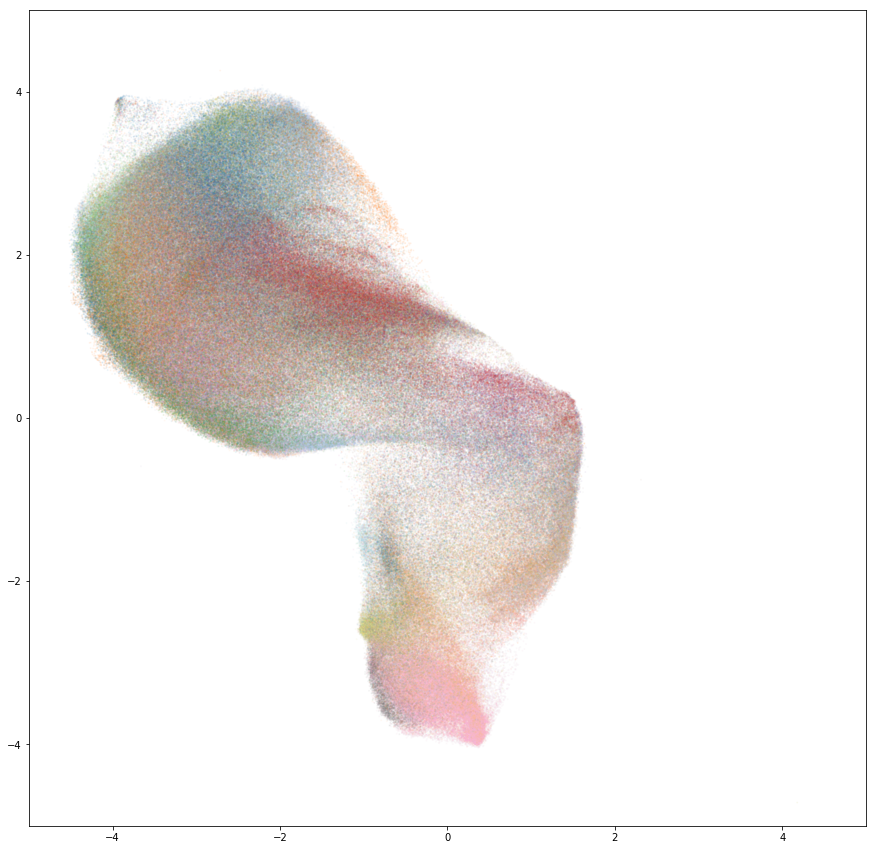

In [18]:
nex = -1
fig, ax = plt.subplots(figsize=(15, 15))
scatter_projections(
    projection=z[:nex],
    alpha=0.05,
    labels=subset_df.labels.values[:nex],
    s=1,
    ax=ax,
    show_legend=False,
)
ax.set_ylim([-5,5])
ax.set_xlim([-5,5])